# Phase II: Data Curation, Exploratory Analysis and Plotting (5\%)

### Group Members: Lauren Cummings, Riyana Roy, Satvik Repaka, Justin Huang

#### Due (Each Group): October 25

Each **project group** will submit a single **jupyter notebook** which contains:

1. (1\%) Expresses the central motivation of the project and explains the (at least) two key questions to be explored. Gives a summary of the data processing pipeline so a technical expert can easily follow along.
2. (2\%) Obtains, cleans, and merges all data sources involved in the project.
3. (2\%) Builds at least two visualizations (graphs/plots) from the data which help to understand or answer the questions of interest. These visualizations will be graded based on how much information they can effectively communicate to readers. Please make sure your visualization are sufficiently distinct from each other.

# Project Details

### **Central Motivation**  
This project aims to understand how tire strategy and weather conditions influence race outcomes. By analyzing these factors together, we aim to gain insights into how teams optimize performance and make decisions under changing conditions.

---

### **Key Questions:**  
1. How does tire strategy impact driver performance and race outcomes under varying weather conditions? 
2. How do changing weather conditions influence pit stop timing and tire choices throughout the race?

---

### **Data Processing Overview:**  

1. **Data Ingestion**: Collect data from race sessions, including event logs, telemetry, and weather data.  

2. **Preprocessing**:  
   - **Laps Data:**  
     - Fill missing pit stop times.  
     - Remove deleted or inaccurate laps.  
     - Map track statuses to meaningful labels (e.g, Safety Car, Yellow Flag).  

   - **Telemetry Data:**    
     - Remove outliers in speed, RPM, and gears.  

   - **Weather Data:**  
     - Align weather timestamps with lap data for consistency.  
     - Filter out unrealistic wind speed values.  
     - Group consecutive rainfall events into a single rain period.  
     - Fill missing temperature and pressure values using forward filling.


3. **Exploratory Data Analysis (EDA)**: Visualize strategy patterns and weather impacts.  
4. **Modeling/Analysis**: Apply statistical methods to find relationships between tires, weather, and strategy.  
5. **Reporting**: Write report to answer the key questions.  



# Imported Libraries

In [18]:
import os
import fastf1
import logging
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Data Retrieval

In [19]:
# Create the directory if it doesn't exist
if not os.path.exists('cache'):
    os.makedirs('cache')

# Enable cache 
fastf1.Cache.enable_cache('cache')

# Suppress INFO and WARNING messages
logging.getLogger('fastf1').setLevel(logging.ERROR)

# Load session data
session = fastf1.get_session(2021, 'Imola', 'R')
session.load()

# Extract data
laps = session.laps
print("Laps Data:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(laps.head())  # Print all columns for the first few rows

fastest_lap = laps.pick_fastest()
telemetry = fastest_lap.get_telemetry()
print("\nTelemetry Data:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(telemetry.head())  # Print all columns for the first few rows

weather = session.weather_data
print("\nWeather Data:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(weather.head())  # Print all columns for the first few rows


Laps Data:
                    Time Driver DriverNumber                LapTime  \
0 0 days 00:35:09.853000    GAS           10 0 days 00:01:54.003000   
1 0 days 00:37:32.883000    GAS           10 0 days 00:02:23.030000   
2 0 days 00:39:53.731000    GAS           10 0 days 00:02:20.848000   
3 0 days 00:42:18.428000    GAS           10 0 days 00:02:24.697000   
4 0 days 00:44:42.360000    GAS           10 0 days 00:02:23.932000   

   LapNumber  Stint PitOutTime PitInTime            Sector1Time  \
0        1.0    1.0        NaT       NaT                    NaT   
1        2.0    1.0        NaT       NaT 0 days 00:00:43.289000   
2        3.0    1.0        NaT       NaT 0 days 00:00:42.977000   
3        4.0    1.0        NaT       NaT 0 days 00:00:42.573000   
4        5.0    1.0        NaT       NaT 0 days 00:00:41.394000   

             Sector2Time            Sector3Time     Sector1SessionTime  \
0 0 days 00:00:37.569000 0 days 00:00:36.794000                    NaT   
1 0 days 00

# Data Cleaning

In [20]:
# Clean Laps Data
# Convert date columns to datetime
for col in ['LapStartTime', 'LapStartDate']:
    if laps[col].dtype == 'object':
        laps[col] = pd.to_datetime(laps[col])

# Identify pit stops
laps['Pitted'] = laps['PitInTime'].notna()

# Adjust PitInTime and PitOutTime: Set to NaN for laps without a pit stop
laps['PitInTime'] = laps['PitInTime'].where(laps['Pitted'], pd.NaT)
laps['PitOutTime'] = laps['PitOutTime'].where(laps['Pitted'], pd.NaT)

# Extract and display pit stop laps
pit_laps = laps[laps['Pitted']]
pit_lap_numbers = pit_laps['LapNumber'].tolist()
print(f"Pit Stop Lap Numbers: {pit_lap_numbers}")

# Remove inaccurate laps
laps = laps[laps['Deleted'] == False]

Pit Stop Lap Numbers: [14.0, 26.0, 32.0, 33.0, 28.0, 33.0, 28.0, 32.0, 33.0, 28.0, 33.0, 27.0, 32.0, 33.0, 25.0, 32.0, 33.0, 27.0, 33.0, 1.0, 27.0, 31.0, 32.0, 33.0, 27.0, 33.0, 28.0, 33.0, 28.0, 31.0, 32.0, 33.0, 5.0, 21.0, 31.0, 32.0, 3.0, 20.0, 22.0, 32.0, 33.0, 61.0, 27.0, 33.0, 26.0, 26.0, 32.0, 33.0, 28.0, 12.0, 23.0, 31.0, 32.0, 27.0, 32.0, 33.0, 40.0]


In [21]:
# Clean Telemetry Data
telemetry = session.laps.pick_fastest().get_telemetry()

# Remove outliers based on speed and RPM
telemetry = telemetry[(telemetry['Speed'] < 350) & (telemetry['RPM'] < 15000)]

# Convert session time to timedelta
telemetry['SessionTime'] = pd.to_timedelta(telemetry['SessionTime'])
if telemetry['Date'].dtype == 'object':
    telemetry['Date'] = pd.to_datetime(telemetry['Date'])

# Fill missing values in telemetry data
telemetry['RPM'].fillna(method='ffill', inplace=True)  # Use forward fill to replace missing values
telemetry['Speed'].fillna(method='ffill', inplace=True)  # Use forward fill to replace missing values

/var/folders/qm/kb15jq7d5kvf69_hpz651m1h0000gn/T/ipykernel_48308/4128003917.py:13: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/qm/kb15jq7d5kvf69_hpz651m1h0000gn/T/ipykernel_48308/4128003917.py:14: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [22]:
# Clean Weather Data
weather = session.weather_data

# Convert weather time to timedelta
weather['Time'] = pd.to_timedelta(weather['Time'])

# Do not fill missing values for weather measurements
# Just keep them as NaN
# Replace any missing values with NaN (pandas already uses NaN by default for missing values)
weather['AirTemp'] = weather['AirTemp'].where(weather['AirTemp'].notna(), other=pd.NA)
weather['Humidity'] = weather['Humidity'].where(weather['Humidity'].notna(), other=pd.NA)
weather['Pressure'] = weather['Pressure'].where(weather['Pressure'].notna(), other=pd.NA)

# Handle rainfall data
weather['Rainfall'].fillna(False, inplace=True)  # Assuming rainfall can be False if unknown
weather['Rainfall'] = weather['Rainfall'].astype(bool)
weather['RainPeriod'] = (weather['Rainfall'] != weather['Rainfall'].shift()).cumsum()

# Forward fill for missing weather values except AirTemp, Humidity, and Pressure
weather[['TrackTemp']] = weather[['TrackTemp']].ffill()  # Forward fill for TrackTemp only

In [23]:
# Adjust Track Status Labels
track_status_mapping = {
    0: 'Green', 
    1: 'Yellow Flag', 
    2: 'Red Flag', 
    3: 'Safety Car', 
    4: 'Virtual Safety Car'
}
if 'TrackStatus' in laps.columns:
    laps['TrackStatus'] = laps['TrackStatus'].map(track_status_mapping)

/var/folders/qm/kb15jq7d5kvf69_hpz651m1h0000gn/T/ipykernel_48308/1439948037.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
#Align Weather Data with Laps Data
# Merge laps and weather data on time
cleaned_data = pd.merge_asof(
    laps.sort_values('Time'),
    weather.sort_values('Time'),
    left_on='Time',  # Align based on lap start time
    right_on='Time',         # Align based on weather time
    # Use previous weather data for the lap
)

In [25]:
# Print only the column names of the aligned data
print(cleaned_data.columns)

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'Pitted', 'AirTemp', 'Humidity',
       'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed',
       'RainPeriod'],
      dtype='object')


In [26]:
# count nan values in each column and print results
nan_counts = cleaned_data.isna().sum()

print("# of NaN values per column:")
for column, count in nan_counts.items():
    print(f"{column}: {count}")

# of NaN values per column:
Time: 0
Driver: 0
DriverNumber: 0
LapTime: 33
LapNumber: 0
Stint: 0
PitOutTime: 1106
PitInTime: 1062
Sector1Time: 40
Sector2Time: 4
Sector3Time: 4
Sector1SessionTime: 42
Sector2SessionTime: 4
Sector3SessionTime: 4
SpeedI1: 116
SpeedI2: 4
SpeedFL: 60
SpeedST: 3
IsPersonalBest: 2
Compound: 0
TyreLife: 0
FreshTyre: 0
Team: 0
LapStartTime: 0
LapStartDate: 2
TrackStatus: 1119
Position: 3
Deleted: 0
DeletedReason: 2
FastF1Generated: 0
IsAccurate: 0
Pitted: 0
AirTemp: 0
Humidity: 0
Pressure: 0
Rainfall: 0
TrackTemp: 0
WindDirection: 0
WindSpeed: 0
RainPeriod: 0


In [27]:
# removing columns we do not need for further analysis
drop_cols = ['IsPersonalBest','DeletedReason']
aligned_data = cleaned_data.drop(columns = drop_cols)

In [28]:
# Ensure all columns are printed without truncation
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("Cleaned Aligned Data (Laps + Weather):")
    print(aligned_data.head())


Cleaned Aligned Data (Laps + Weather):
                    Time Driver DriverNumber                LapTime  \
0 0 days 00:34:54.453000    VER           33 0 days 00:01:38.603000   
1 0 days 00:34:54.453000    LAT            6                    NaT   
2 0 days 00:34:58.422000    HAM           44 0 days 00:01:42.572000   
3 0 days 00:35:03.048000    LEC           16 0 days 00:01:47.198000   
4 0 days 00:35:03.664000    PER           11 0 days 00:01:47.814000   

   LapNumber  Stint PitOutTime PitInTime Sector1Time            Sector2Time  \
0        1.0    1.0        NaT       NaT         NaT 0 days 00:00:32.907000   
1        1.0    1.0        NaT       NaT         NaT                    NaT   
2        1.0    1.0        NaT       NaT         NaT 0 days 00:00:34.735000   
3        1.0    1.0        NaT       NaT         NaT 0 days 00:00:36.228000   
4        1.0    1.0        NaT       NaT         NaT 0 days 00:00:36.128000   

             Sector3Time Sector1SessionTime     Sector2Sess

## Graphs

In [29]:
# Convert RainPeriod and Rainfall to string for labeling
aligned_data['RainPeriod'] = aligned_data['RainPeriod'].astype(str)  
aligned_data['Rainfall'] = aligned_data['Rainfall'].astype(str)  

# Create a count of compounds based on rain periods and rainfall
compound_rain_counts = aligned_data.groupby(['Compound', 'RainPeriod', 'Rainfall']).size().reset_index(name='Count')

# Create the bar plot
fig = px.bar(
    compound_rain_counts,
    x='Compound',
    y='Count',
    color='RainPeriod',  
    facet_row='Rainfall',  
    title='Distribution of Tire Compounds Based on Rain Period and Rainfall',
    labels={'RainPeriod': 'Rain Period', 'Rainfall': 'Rainfall'},
    barmode='group',  
    color_discrete_sequence=px.colors.qualitative.Set2
)


fig.show()


The graph shows the relationship between tire strategy (compound choice), weather conditions (rain periods), and if rainfall is true or not. By analyzing this information, teams can find tire performance and make decisions for future races regarding tire selection in varying weather scenarios. Not only this but comparing tire compound usage during rain vs. no rain can show how well they performed in the race and actually predicting whether there is going to be rain or not. This analysis helps in optimizing tire strategies and improving overall race performance under similar conditions.

In [30]:
# Calculate the average sector times for each compound
average_sector_times = aligned_data.groupby('Compound')[['Sector1Time', 'Sector2Time', 'Sector3Time']].mean().reset_index()

# Melt the DataFrame to have a long format for plotting
melted_sector_times = average_sector_times.melt(id_vars='Compound', 
                                                 value_vars=['Sector1Time', 'Sector2Time', 'Sector3Time'], 
                                                 var_name='Sector', 
                                                 value_name='AverageTime')

# Convert AverageTime to seconds for easier interpretation
melted_sector_times['AverageTime'] = melted_sector_times['AverageTime'].dt.total_seconds()

# Create the plot
fig = px.bar(
    melted_sector_times,
    x='Compound',
    y='AverageTime',
    color='Sector',
    barmode='group',
    title='Average Sector Times by Tire Compound',
    labels={'AverageTime': 'Average Sector Time (seconds)', 'Compound': 'Tire Compound'},
    color_discrete_sequence=px.colors.qualitative.Set2
)


fig.show()


The graph shows how different tire compounds perform in terms of sector times during the race. By seeing this data, teams and analysts can gain information in terms of tire performance and make data-driven decisions for future races.  If one compound consistently shows shorter average times across all sectors, it suggests that this tire performs better in terms of speed in those specific sectors. This information is critical for making race strategies, tire selection, and the impact of tire choice on overall race performance.

In [31]:
# Identify pit stops
laps['Pitted'] = laps['PitInTime'].notna()

# Filter to get only the laps where a pit stop occurred
pit_stops = laps[laps['Pitted']][['Driver', 'LapNumber', 'Time']]

# Merge laps data with weather data to include Track Temperature
merged_data = pd.merge_asof(
    pit_stops.sort_values('Time'),
    weather.sort_values('Time'),
    left_on='Time',
    right_on='Time',  # Align based on time
)

# Include Track Temperature in the DataFrame
merged_data = merged_data[['Driver', 'LapNumber', 'TrackTemp']]

# Create the Plot
fig = px.scatter(
    merged_data,
    x='LapNumber',
    y='TrackTemp',
    color='Driver',
    title='Track Temperature at Pit Stops by Driver',
    labels={'LapNumber': 'Lap Number', 'TrackTemp': 'Track Temperature (°C)'},
    hover_data=['Driver']
)

# Show the plot
fig.show()


/var/folders/qm/kb15jq7d5kvf69_hpz651m1h0000gn/T/ipykernel_48308/3659306680.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The scatter plot shows track temperature varied at the time of pit stops for different drivers. It displays how often drivers do pit stops based on the Track Temperature. You can analyze how track temperature changes throughout the race. For instance, if the track temperature consistently increases or decreases as the race goes on, it may impact tire performance and pit strategies. If the track temperature is higher there would be increased pit stops as the track temp runs down the wheels more. However, when the Track Temperature is cooler it runs the wheel less meaning the drivers are less likely to stop for a pit. By finding these patterns, teams and analysts can make informed decisions about tire strategies and pit stop timing in future races.


In [32]:
# Identify pit stops
laps['Pitted'] = laps['PitInTime'].notna()

# Filter to get only the laps where a pit stop occurred
pit_stops = laps[laps['Pitted']][['Driver', 'LapNumber', 'Time', 'Compound']]

# Merge laps data with weather data to include Rain Period
merged_data = pd.merge_asof(
    pit_stops.sort_values('Time'),
    weather.sort_values('Time'),
    left_on='Time',
    right_on='Time',  # Align based on time
)

# Add Rain Period to the DataFrame
merged_data['RainPeriod'] = merged_data['Rainfall'].apply(lambda x: 'Wet' if x > 0 else 'Dry')

# Create the Plot as a scatter plot
fig = px.scatter(
    merged_data,
    x='LapNumber',
    y='Compound',
    color='RainPeriod',
    title='Driver Compound during Race Laps Colored by Rain Period',
    labels={'LapNumber': 'Lap Number', 'Compound': 'Tire Compound'},
    hover_data=['Driver', 'RainPeriod']  
)

# Show the plot
fig.show()


/var/folders/qm/kb15jq7d5kvf69_hpz651m1h0000gn/T/ipykernel_48308/3590394635.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The scatter plot shows how different drivers managed their tire choices during the race in relation to changing weather conditions. It is clear of the distribution of tire compounds during different laps, where you can analyze how weather conditions influenced tire strategy. For example, the driver can use the wet compound during the lap when there is rainfall and predict when it is going to stop to then switch during their pit to have a better compound for when it is dry. It makes it so that drivers adapt their strategy based on the rain conditions. Understanding the impact of rain periods on tire selection can help with pit strategies in response to rain and other weather anomalies. 


In [33]:
# Select relevant columns
start_end_positions = laps[['Driver', 'Position', 'LapNumber']].copy()

# Get starting positions 
start_positions = start_end_positions[start_end_positions['LapNumber'] == 1].rename(columns={'Position': 'Start Position'})

# Get ending positions 
end_positions = start_end_positions[start_end_positions['LapNumber'] == laps['LapNumber'].max()].rename(columns={'Position': 'End Position'})

# Merge start and end positions
positions = pd.merge(start_positions[['Driver', 'Start Position']], 
                     end_positions[['Driver', 'End Position']], 
                     on='Driver')

# Create the bar chart
fig = go.Figure()

# Add bars for starting positions
fig.add_trace(go.Bar(
    x=positions['Driver'],
    y=positions['Start Position'],
    name='Start Position',
    marker_color='blue'
))

# Add bars for ending positions
fig.add_trace(go.Bar(
    x=positions['Driver'],
    y=positions['End Position'],
    name='End Position',
    marker_color='red'
))

# Update layout
fig.update_layout(
    title='Driver Starting and Ending Positions',
    xaxis_title='Driver',
    yaxis_title='Position',
    barmode='group',
    legend_title='Position Type',
    yaxis=dict(dtick=1)  
)


fig.show()


The graph shows the starting and ending positions of drivers in a race displaying how well they did in the race. Each blue bar represents the starting position of the corresponding driver at the beginning of the race and the red bar indicates the ending position of the driver after the race. With this graph we can see what each driver did through the other graph such as the tire compound they used during the rain, when they did their pit, and how wind speed affected the race. This all shows us the different strategies each driver had during these weather conditions and whether the worker displayed it they performed better or worse if they did not which influences the final standings. 


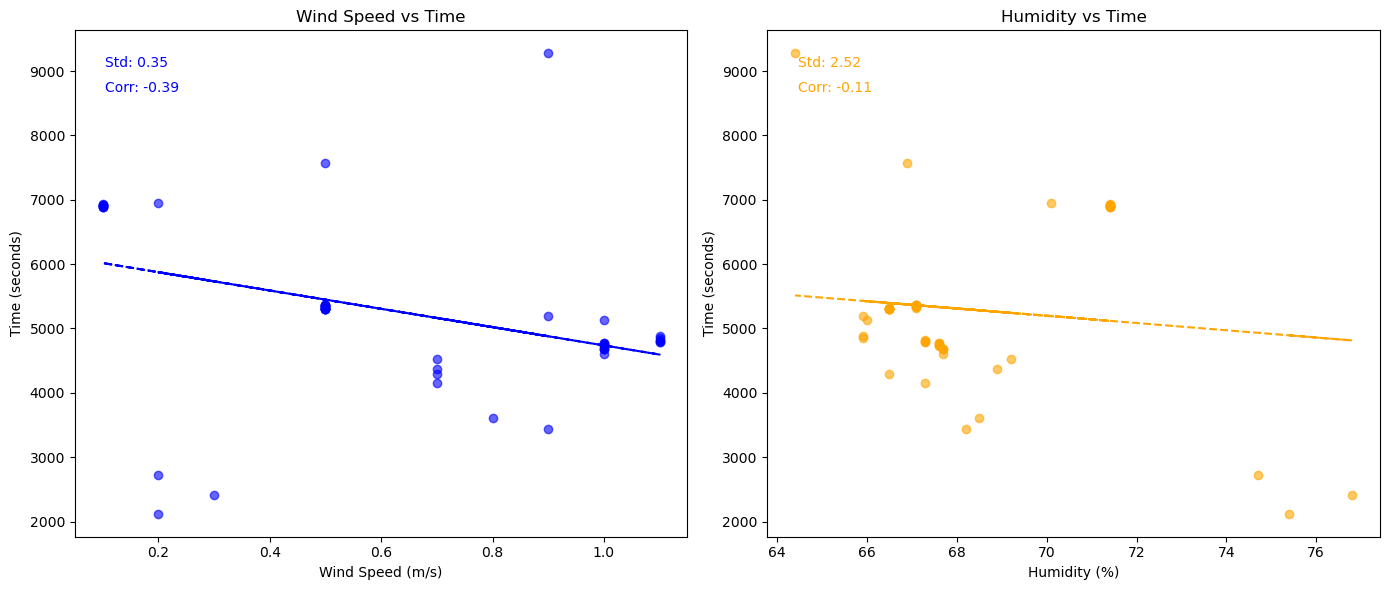

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

merged_data['Time_seconds'] = merged_data['Time'].dt.total_seconds()

wind_speed_std = merged_data['WindSpeed'].std()
wind_speed_corr = merged_data[['WindSpeed', 'Time_seconds']].corr().iloc[0, 1]

humidity_std = merged_data['Humidity'].std()
humidity_corr = merged_data[['Humidity', 'Time_seconds']].corr().iloc[0, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(merged_data['WindSpeed'], merged_data['Time_seconds'], color='blue', alpha=0.6)
z1 = np.polyfit(merged_data['WindSpeed'], merged_data['Time_seconds'], 1)
p1 = np.poly1d(z1)
ax1.plot(merged_data['WindSpeed'], p1(merged_data['WindSpeed']), color='blue', linestyle='--')

ax1.set_ylabel('Time (seconds)')
ax1.set_xlabel('Wind Speed (m/s)')
ax1.set_title('Wind Speed vs Time')

ax1.text(0.05, 0.95, f'Std: {wind_speed_std:.2f}', transform=ax1.transAxes, verticalalignment='top', color='blue')
ax1.text(0.05, 0.90, f'Corr: {wind_speed_corr:.2f}', transform=ax1.transAxes, verticalalignment='top', color='blue')

ax2.scatter(merged_data['Humidity'], merged_data['Time_seconds'], color='orange', alpha=0.6)
z2 = np.polyfit(merged_data['Humidity'], merged_data['Time_seconds'], 1)
p2 = np.poly1d(z2)
ax2.plot(merged_data['Humidity'], p2(merged_data['Humidity']), color='orange', linestyle='--')

ax2.set_ylabel('Time (seconds)')
ax2.set_xlabel('Humidity (%)')
ax2.set_title('Humidity vs Time')

ax2.text(0.05, 0.95, f'Std: {humidity_std:.2f}', transform=ax2.transAxes, verticalalignment='top', color='orange')
ax2.text(0.05, 0.90, f'Corr: {humidity_corr:.2f}', transform=ax2.transAxes, verticalalignment='top', color='orange')

plt.tight_layout()
plt.show()

The above two graphs vizualize Wind speed and Humidity and their affects on a drivers time. As seen in the graphs, both of these relationships show a very weak negative correlation with outliers (especially for windspeed). Additionally, the large standard deviation in the Humidity Graph indicates large variability. 

In [ ]:
#Turn HumidityLevel to string for labeling
aligned_data['HumidityLevel'] = aligned_data['Humidity'].astype(str)

#make a count of compounds based on humidity levels
compound_humidity_counts = aligned_data.groupby(['Compound', 'HumidityLevel']).size().reset_index(name='Count')

#create the plot
fig = px.bar(
    compound_humidity_counts,
    x='Compound',
    y='HumidityLevel',
    color='blue',  
    title='Distribution of Tire Compounds Based on Humidity Levels',
    labels={'HumidityLevel': 'Humidity Level'},
    barmode='group',  
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.show()

The graph shows teams’ strategic tire choice according to humidity conditions showing how different compounds are used for performance and risks on varying track surfaces and the humidity affecting the track. For example, high humidity can affect the drivers driving itself causing them to sweat as well as also affect the car with the cooling system changing the way they drive. This provides information on optimizing race strategies and tire selection especially depending on high, medium, or low humidity. 
